In [18]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.backend import clear_session
from keras.layers import Dense, Conv2D, BatchNormalization
from keras.layers import InputLayer, Flatten, Dropout, MaxPool2D
from keras import Sequential
import pickle
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [20]:
cifar10 = keras.datasets.cifar10
(xtrain, ytrain), (xtest, ytest) = cifar10.load_data()

In [21]:
animal_idxs = (2, 3, 4, 5, 6, 7)

In [22]:
fmap = np.vectorize(lambda x:int(x in animal_idxs))

In [23]:
ytrain, ytest = fmap(ytrain), fmap(ytest)

In [24]:
xtrain, xtest = xtrain / 255, xtest / 255

In [25]:
cnn = Sequential([
    InputLayer(input_shape=(32,32,3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Flatten(),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])

cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
# hist2 = cnn.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=50)

# cnn.save_weights('/content/drive/MyDrive/cnn_project_weights.weights.h5')
# pickle.dump(hist2.history,open('cnn_project_history.pkl','wb'))

In [27]:
cnn.load_weights('cnn_project_weights.weights.h5')
hist2 = pickle.load(open('cnn_project_history.pkl', 'rb'))

In [28]:
ypred = (cnn.predict(xtest) > 0.5).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


In [29]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4000
           1       0.97      0.97      0.97      6000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [30]:
confusion_matrix(ytest, ypred)

array([[3814,  186],
       [ 182, 5818]])

182 animali sono stati misclassificati come veicoli <br>
186 veicoli sono stati misclassificati come animali

In [31]:
def analyze_errors(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Matrice di Confusione')
    plt.xlabel('Predetto')
    plt.ylabel('Reale')
    
    print(classification_report(y_true, y_pred, target_names=class_names))

In [32]:
def analyze_binary_errors(y_true, y_pred, images, confidence_scores=None):
    # 1. Identificazione errori
    errors_idx = np.where(y_true != y_pred)[0]
    false_positives = np.where((y_pred == 1) & (y_true == 0))[0]
    false_negatives = np.where((y_pred == 0) & (y_true == 1))[0]
    
    print(f"Numero totale di errori: {len(errors_idx)}")
    print(f"Falsi Positivi: {len(false_positives)}")
    print(f"Falsi Negativi: {len(false_negatives)}")
    
    # 2. Matrice di confusione
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Veicoli', 'Animali'],
                yticklabels=['Veicoli', 'Animali'])
    plt.title('Matrice di Confusione')
    plt.xlabel('Predetto')
    plt.ylabel('Reale')
    plt.show()
    
    # 3. Analisi dettagliata degli errori più frequenti
    def visualize_misclassified_examples(indices, title, n_examples=5):
        n = min(n_examples, len(indices))
        if n == 0:
            print(f"Nessun esempio trovato per {title}")
            return
            
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(indices[:n]):
            plt.subplot(1, n, i+1)
            plt.imshow(images[idx])
            if confidence_scores is not None:
                conf = confidence_scores[idx]
                plt.title(f'Conf: {conf:.2f}')
            plt.axis('off')
        plt.suptitle(title)
        plt.show()
    
    # Visualizza esempi di falsi positivi
    visualize_misclassified_examples(
        false_positives, 
        'Esempi di Falsi Positivi (predetti come Animali, realmente Veicoli)'
    )
    
    # Visualizza esempi di falsi negativi
    visualize_misclassified_examples(
        false_negatives, 
        'Esempi di Falsi Negativi (predetti come Veicoli, realmente Animali)'
    )
    
    # 5. Report delle metriche
    print("\nReport di Classificazione:")
    print(classification_report(y_true, y_pred, target_names=['Classe 0', 'Classe 1']))

def analyze_error_patterns(images, errors_idx):
    # Calcola statistiche base sulle immagini errate
    error_images = images[errors_idx]
    
    # Esempio di analisi: media e deviazione standard dell'intensità
    mean_intensity = np.mean(error_images, axis=(1,2))
    std_intensity = np.std(error_images, axis=(1,2))
    
    plt.figure(figsize=(12, 4))
    
    # Distribuzione dell'intensità media
    plt.subplot(1, 2, 1)
    plt.hist(mean_intensity, bins=30)
    plt.title('Distribuzione Intensità Media\nImmagini Errate')
    plt.xlabel('Intensità Media')
    plt.ylabel('Frequenza')
    
    # Distribuzione della deviazione standard
    plt.subplot(1, 2, 2)
    plt.hist(std_intensity, bins=30)
    plt.title('Distribuzione Std Dev\nImmagini Errate')
    plt.xlabel('Deviazione Standard')
    plt.ylabel('Frequenza')
    
    plt.tight_layout()
    plt.show()

Numero totale di errori: 368
Falsi Positivi: 186
Falsi Negativi: 182


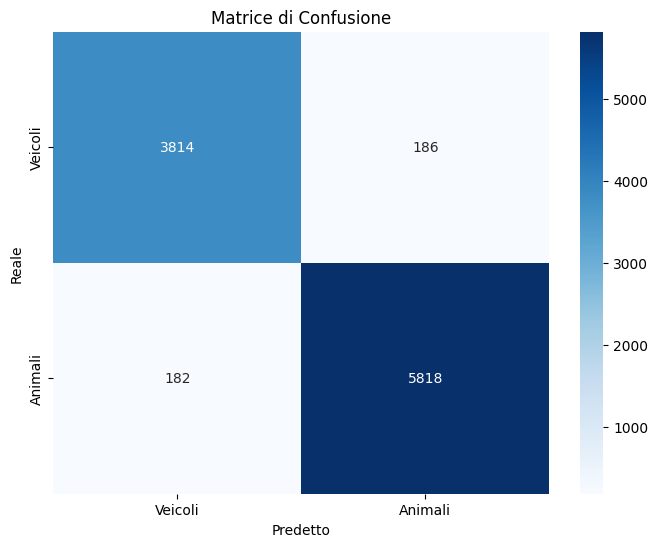

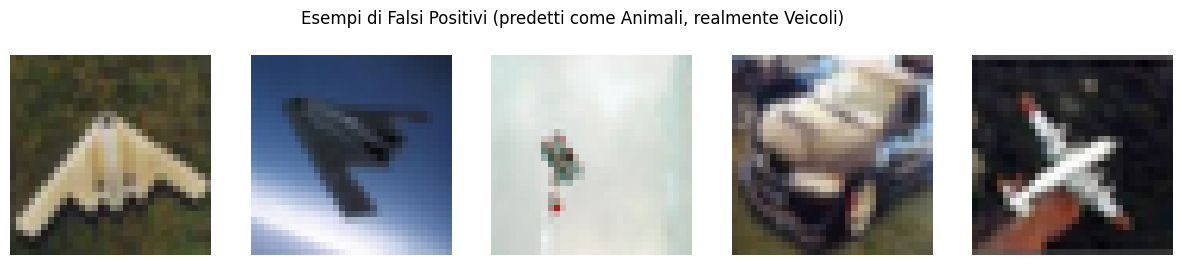

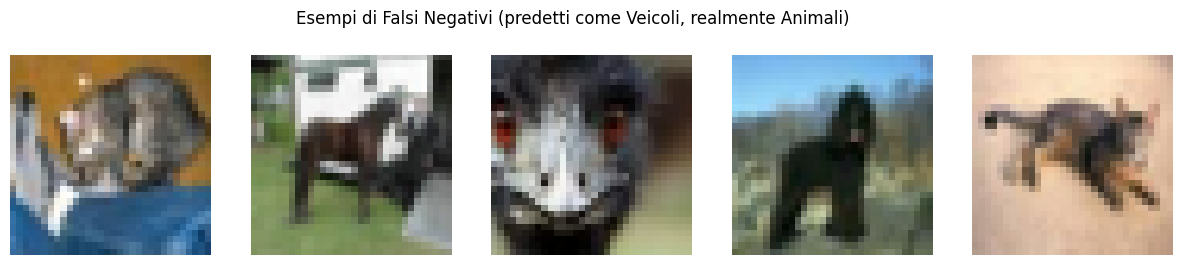


Report di Classificazione:
              precision    recall  f1-score   support

    Classe 0       0.95      0.95      0.95      4000
    Classe 1       0.97      0.97      0.97      6000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [33]:
analyze_binary_errors(ytest, ypred, xtest)

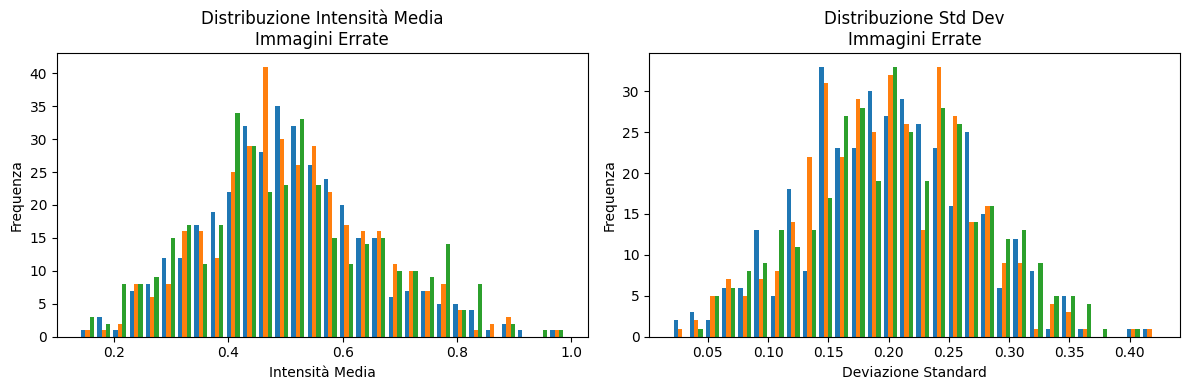

In [34]:
errors_idx = np.where(ytest != ypred)[0]
analyze_error_patterns(xtest, errors_idx)

Il grafico di sinistra mostra la frequenza di distribuzione dei valori di intensità media delle immagini. Sull'asse orizzontale troviamo l'intensità media normalizzata, che spazia da 0.2 a 1.0, mentre sull'asse verticale è rappresentata la frequenza, ovvero il numero di immagini per ogni intervallo di intensità. La distribuzione rivela una concentrazione significativa di valori nell'intervallo 0.4-0.5, suggerendo che la maggior parte delle immagini errate presenta un'intensità media in questo range. La forma della distribuzione appare approssimativamente gaussiana, con code simmetriche su entrambi i lati.
Il grafico di destra rappresenta invece la variabilità dell'intensità all'interno delle singole immagini. L'asse orizzontale, che va da 0.05 a 0.40, mostra i valori della deviazione standard, mentre l'asse verticale indica nuovamente la frequenza. In questo caso, si osserva una concentrazione maggiore di valori nell'intervallo 0.15-0.25, indicando che questo è il range più comune di variabilità interna delle immagini errate. La distribuzione presenta una leggera asimmetria positiva, con una coda più estesa verso i valori maggiori.